In [1]:
# Standard library imports
import time
import concurrent.futures
from math import tanh, sqrt, fabs, erf as math_erf

# Third-party imports

# Numerical computations
import numpy as np
from numpy.polynomial import Chebyshev

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.widgets import Slider

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, Output, RadioButtons

# Scientific computing
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.interpolate import UnivariateSpline, interp1d

# Performance enhancement
from numba import njit

# Workflow for Color Fringe Computation and Chromatic Correction
This document outlines the steps needed to simulate chromatic aberration effects, including data import, interpolation, interactive curve fitting, and analysis of color fringe width. The simulation takes into account the physics of chromatic aberration, sensor response, and overexposure effects.

## 1. Data Import

In [2]:
# -----------------------------------------------------------------------------
# Import Longitudinal Chromatic Aberration Data
# -----------------------------------------------------------------------------
# Input: 
#    - wavelengths_CHL: wavelengths from 400 to 700 nm (10 nm steps)
#    - defocus_values: 31 defocus values (µm) corresponding to each wavelength
#
# Process:
#    - Combine wavelengths and defocus values into a (31, 2) array
#
# Output:
#    - CHLzf85: a (31, 2) NumPy array with columns [wavelength, defocus value]
# -----------------------------------------------------------------------------

wavelengths_CHL = np.arange(400, 701, 10)
values_defocus = [
    285.0, 190.0, 118.0, 63.0, 22.0, -9.0, -31.0, -46.0, -56.0, -62.0,
    -64.0, -63.0, -60.0, -54.0, -48.0, -39.0, -30.0, -20.0, -9.0, 3.0,
    15.0, 28.0, 41.0, 54.0, 68.0, 82.0, 96.0, 111.0, 125.0, 139.0, 156.0
]

CHLzf85 = np.column_stack((wavelengths_CHL, values_defocus))
print("CHLzf85 shape:", CHLzf85.shape)

CHLzf85 shape: (31, 2)


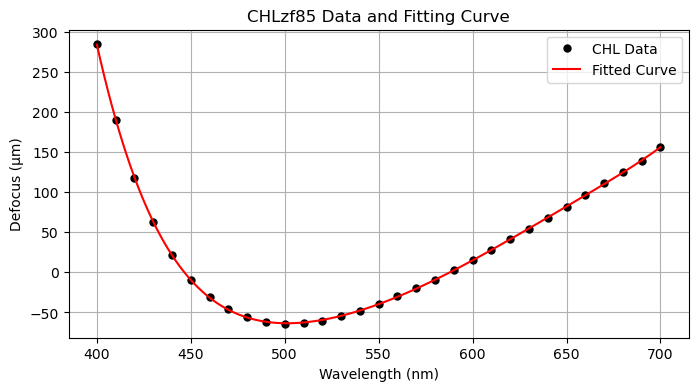

Fitted CHL coefficients: [ 6.17055255e-12 -2.17284405e-08  3.18690992e-05 -2.49424071e-02
  1.09994225e+01 -2.59404221e+03  2.55683162e+05]
CHL_fit shape: (300,)


In [3]:
# -----------------------------------------------------------------------------
# CHL Data Extraction and Fitting
# -----------------------------------------------------------------------------
# Input:
#    - CHLzf85: a (31, 2) NumPy array with columns [wavelength, defocus value]
#
# Process:
#    - Extract wavelength and defocus values.
#    - Fit a 6th-degree polynomial.
#    - Generate a smooth fitting curve (400-700 nm, 1 nm steps).
#
# Output:
#    - CHL_fit: fitted defocus values on a fine grid.
#
# Note:
#    - x_CHL: global sampling grid (400-700 nm, 10 nm steps)
#    - x_fit: global fitting grid (400-700 nm, 1 nm steps)
#    - CHLFit: a function for evaluating the polynomial fit.
# -----------------------------------------------------------------------------

x_CHL = CHLzf85[:, 0]
y_CHL = CHLzf85[:, 1]

CHL_coeffs = np.polyfit(x_CHL, y_CHL, 6)

def CHLFit(x):
    return np.polyval(CHL_coeffs, x)

x_fit = np.linspace(400, 700, 300)
CHL_fit = CHLFit(x_fit)

plt.figure(figsize=(8, 4))
plt.plot(x_CHL, y_CHL, 'o', markersize=5, color='black', label='CHL Data')
plt.plot(x_fit, CHL_fit, '-', color='red', label='Fitted Curve')
plt.title('CHLzf85 Data and Fitting Curve')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Defocus (µm)')
plt.legend()
plt.grid(True)
plt.show()

print("Fitted CHL coefficients:", CHL_coeffs)
print("CHL_fit shape:", CHL_fit.shape)

In [4]:
# -----------------------------------------------------------------------------
# Import Light Source Data
# -----------------------------------------------------------------------------
# Input: 
#    - wavelengths_daylight: wavelengths from 380 to 690 nm (10 nm steps)
#    - daylight_values: 32 intensity values corresponding to each wavelength
#
# Process:
#    - Combine wavelengths and intensity values into a (32, 2) array
#
# Output:
#    - Daylight_in: a (32, 2) NumPy array with columns [wavelength, intensity]
# -----------------------------------------------------------------------------

wavelengths_daylight = np.arange(380, 691, 10)
values_daylight = [
    11, 16, 22, 33, 48, 62, 71, 78, 84, 92,
    97, 100, 96, 95, 95, 94, 90, 78, 70, 78,
    88, 94, 91, 85, 82, 85, 92, 100, 89, 76,
    83, 100
]

Daylight_in = np.column_stack((wavelengths_daylight, values_daylight))
print("Daylight_in shape:", Daylight_in.shape)

Daylight_in shape: (32, 2)


In [5]:
# -----------------------------------------------------------------------------
# Import Sensor Response Data
# -----------------------------------------------------------------------------
# Input:
#    - wavelengths: wavelengths from 400 to 700 nm (10 nm steps)
#    - sensor_values: a dictionary containing three sensor channels(Blue, Green, Red),
#      each with 31 sensitivity values corresponding to the wavelengths.
#
# Process:
#    - For each sensor channel, combine wavelengths and sensitivity values into a (31, 2) NumPy array.
#
# Output:
#    - sensors: a dictionary where each key is a sensor channel name and each value is
#      a (31, 2) NumPy array with columns [wavelength, sensitivity].
# -----------------------------------------------------------------------------

wavelengths_sensor = np.arange(400, 701, 10)

values_sensor = {
    "SensorBlue": [
        0.42, 9.08, 24.34, 28.37, 40.12, 39.01, 47.12, 46.65, 41.14, 26.73,
        14.75, 7.55, 2.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.69, 0.84, 0.32, 0.04, 0.0
    ],
    "SensorGreen": [
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.63, 6.48, 9.09,
        17.75, 28.39, 37.8, 38.39, 35.02, 28.83, 28.1, 19.02, 13.1, 6.96,
        4.33, 3.34, 3.02, 0.0, 0.0, 0.0, 0.69, 0.7, 0.34, 0.05, 0.0
    ],
    "SensorRed": [
        0.0, 1.3, 1.86, 2.17, 1.73, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.38, 60.18, 100.0,
        92.73, 72.75, 50.6, 35.81, 35.08, 22.4, 16.96, 7.75, 3.3, 0.78, 0.18
    ]
}

# Create the dictionary with each sensor channel as a (31, 2) array
sensors_in = {name: np.column_stack((wavelengths_sensor, values))
           for name, values in values_sensor.items()}

# Extract the individual sensor arrays
SensorBlue = sensors_in["SensorBlue"]
SensorGreen = sensors_in["SensorGreen"]
SensorRed = sensors_in["SensorRed"]

# Optional: Display the shapes to verify they are (31, 2)
print("SensorBlue shape:", SensorBlue.shape)
print("SensorGreen shape:", SensorGreen.shape)
print("SensorRed shape:", SensorRed.shape)

SensorBlue shape: (31, 2)
SensorGreen shape: (31, 2)
SensorRed shape: (31, 2)


Resampled Daylight Spectrum: (31, 2)


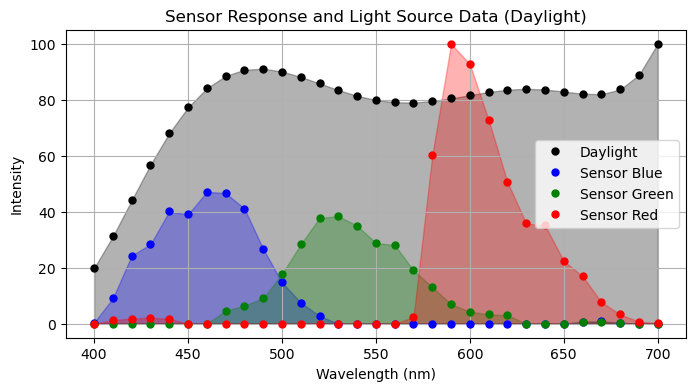

Sensor Blue normalized integral: 0.9999999999999999
Sensor Green normalized integral: 1.0
Sensor Red normalized integral: 1.0


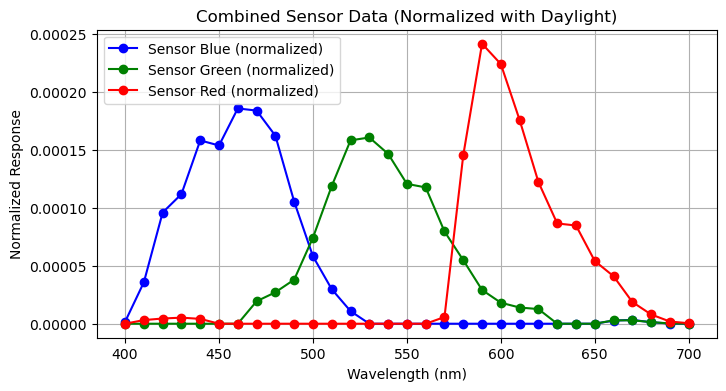

SensorBlue_norm shape: (31, 2)
SensorGreen_norm shape: (31, 2)
SensorRed_norm shape: (31, 2)


In [6]:
# -----------------------------------------------------------------------------
# Sensor Response and Daylight Spectrum Processing
# -----------------------------------------------------------------------------
# Input:
#    - Daylight_in: Daylight spectrum (NumPy array with columns [wavelength, intensity])
#    - x_CHL: Global wavelength grid (e.g., from CHL data)
#    - SensorBlue, SensorGreen, SensorRed: Sensor response arrays ([wavelength, intensity])
#
# Process:
#    - Resample Daylight_in via a 6th-degree polynomial fit and normalize (max = 100).
#    - Plot the resampled Daylight with the raw sensor responses.
#    - Compute normalization factors (via integration against daylight intensity)
#       and adjust each sensor so that ∫[Sensor * Daylight] dλ ≈ 1.
#    - Plot the normalized sensor responses.
#
# Output:
#    - Normalized sensor arrays: SensorBlue_norm, SensorGreen_norm, SensorRed_norm
# -----------------------------------------------------------------------------

def resample_spectrum_poly(spectrum, new_wavelengths, degree=6):
    """
    Resamples a given spectrum using a 6th-degree polynomial fit and normalizes its maximum to 100.
    """
    wavelengths, intensities = spectrum[:, 0], spectrum[:, 1]
    coeffs = np.polyfit(wavelengths, intensities, degree)
    new_intensities = np.poly1d(coeffs)(new_wavelengths)
    new_intensities = new_intensities / np.max(new_intensities) * 100
    return np.column_stack((new_wavelengths, new_intensities))

def plot_with_fill(x, y, color, marker='o', markersize=5, label=None):
    """
    Utility function to plot data points and fill under the curve.
    """
    plt.plot(x, y, marker, markersize=markersize, color=color, label=label)
    plt.fill_between(x, y, color=color, alpha=0.3)

def compute_norm(sensor, daylight_intensity, wavelengths):
    """
    Computes the normalization factor for a sensor such that the integral of the
    product of sensor response and daylight intensity is ~1.
    """
    sensor_response = sensor[:, 1]
    integral = np.trapezoid(sensor_response * daylight_intensity, x=wavelengths)
    norm_factor = 1 / integral if integral != 0 else 0
    return norm_factor, integral

# ======================== Part 1: Resample & Plot =============================
# Resample the Daylight spectrum
Daylight = resample_spectrum_poly(Daylight_in, x_CHL, degree=6)
print("Resampled Daylight Spectrum:", Daylight.shape)

plt.figure(figsize=(8, 4))
# Plot resampled Daylight spectrum
plot_with_fill(Daylight[:, 0], Daylight[:, 1], color='black', label='Daylight')

# Plot raw sensor responses using a dictionary for brevity
sensors = {
    "Sensor Blue": (SensorBlue, 'blue'),
    "Sensor Green": (SensorGreen, 'green'),
    "Sensor Red": (SensorRed, 'red')
}
for sensor_name, (sensor_data, color) in sensors.items():
    plot_with_fill(sensor_data[:, 0], sensor_data[:, 1], color=color, label=sensor_name)

plt.title('Sensor Response and Light Source Data (Daylight)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()

# =================== Part 2: Normalize & Plot Sensor Data (Concise with Correct Colors) =====================
daylight_intensity = Daylight[:, 1]

# Create a dictionary for storing normalized sensor arrays with their colors.
normSensors = {}

# Process each sensor: compute normalization factor, normalize data, and store with its color.
for sensor_name, (sensor_data, color) in sensors.items():
    norm_factor, _ = compute_norm(sensor_data, daylight_intensity, x_CHL)
    normalized_sensor = sensor_data.copy()
    normalized_sensor[:, 1] *= norm_factor
    normSensors[sensor_name] = (normalized_sensor, color)
    norm_integral = np.trapezoid(normalized_sensor[:, 1] * daylight_intensity, x=x_CHL)
    print(f"{sensor_name} normalized integral: {norm_integral}")

# Plot the normalized sensor responses, ensuring the correct color is used for each.
plt.figure(figsize=(8, 4))
for sensor_name, (normalized_sensor, color) in normSensors.items():
    plt.plot(x_CHL, normalized_sensor[:, 1], 'o-', color=color, label=f'{sensor_name} (normalized)')
plt.title('Combined Sensor Data (Normalized with Daylight)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Response')
plt.legend()
plt.grid(True)
plt.show()

# Final output: Extract and output the normalized sensor arrays.
SensorBlue_norm = normSensors["Sensor Blue"][0]
SensorGreen_norm = normSensors["Sensor Green"][0]
SensorRed_norm = normSensors["Sensor Red"][0]

print("SensorBlue_norm shape:", SensorBlue_norm.shape)
print("SensorGreen_norm shape:", SensorGreen_norm.shape)
print("SensorRed_norm shape:", SensorRed_norm.shape)

## 2. CHL Curve Modification and Visualization

In [7]:
# -----------------------------------------------------------------------------
# Modified CHL Curve Generation and Sampling
# -----------------------------------------------------------------------------
# This script demonstrates how to modify an existing CHL (defocus) curve by applying
# a horizontal shift and a tilt factor about a pivot point determined from the original
# curve. The modifications are made by adjusting the derivative of the CHL curve and then
# reconstructing the modified curve via numerical integration.
#
# Process:
#   - Pre-calculations: Determine the wavelength interval and the original minimum of the CHL curve.
#   - Interpolators: 
#         * A linear interpolator for the right section of the curve.
#         * A spline interpolator for the left section with zero smoothing.
#   - CHLFit_mod_overall: Computes the modified CHL curve with adjustable pivot shift and tilt.
#   - extract_sampled_modified_values_overall: Samples the modified curve at 10 nm intervals
#     between 400 nm and 700 nm, returning a two-column array (wavelength and floored CHL value)
# -----------------------------------------------------------------------------

# Pre-calculations and Setup
dx = x_fit[1] - x_fit[0]
min_idx = np.argmin(CHL_fit)
x_min, y_min = x_fit[min_idx], CHL_fit[min_idx]
print("Original lowest point at x = {:.2f} nm, y = {:.2f}".format(x_min, y_min))

linear_fit = interp1d(x_fit, CHL_fit, kind='linear', fill_value="extrapolate")
spline_fit = UnivariateSpline(x_fit, CHL_fit, s=0)

def CHLFit_mod_overall(x_vals, x_shift=0.0, tilt=0.0):
    """
    Apply a horizontal shift and tilt to modify the CHL curve.
    For x < pivot: derivative scaled by (1 - tilt)
    For x >= pivot: derivative scaled by (1 + tilt)
    
    Parameters:
        x_vals (array): Wavelength values.
        x_shift (float): Pivot shift.
        tilt (float): Tilt factor.
    
    Returns:
        np.ndarray: Modified CHL curve values.
    """
    # Determine the local spacing for the current x_vals
    local_dx = x_vals[1] - x_vals[0]
    
    pivot_x = x_min + x_shift  
    pivot_y = CHLFit(x_min)  # External CHL evaluation function
    x_shifted = x_vals - x_shift
    
    deriv_left = spline_fit.derivative()(x_shifted)
    deriv_right = np.gradient(linear_fit(x_shifted), local_dx)
    base_deriv = np.where(x_vals < pivot_x, deriv_left, deriv_right)
    new_deriv = np.where(x_vals < pivot_x, base_deriv * (1 - tilt), base_deriv * (1 + tilt))
    
    g = np.empty_like(x_vals)
    pivot_index = np.argmin(np.abs(x_vals - pivot_x))
    g[pivot_index] = pivot_y
    if pivot_index < len(x_vals) - 1:
        g[pivot_index + 1:] = pivot_y + np.cumsum(new_deriv[pivot_index:-1]) * local_dx
    if pivot_index > 0:
        g[:pivot_index] = pivot_y - np.cumsum(new_deriv[1:pivot_index + 1][::-1])[::-1] * local_dx
    
    return g

def extract_sampled_modified_values_overall(x_shift=0.0, tilt=0.0):
    """
    Sample the modified CHL curve every 10 nm from 400 nm to 700 nm.
    
    Returns:
        np.ndarray: Two-column array (wavelength, floored CHL value).
    """
    x_sample = np.arange(400, 701, 10)
    y_sample = CHLFit_mod_overall(x_sample, x_shift, tilt)
    return np.column_stack((x_sample, np.floor(y_sample)))

Original lowest point at x = 501.34 nm, y = -63.42


In [32]:
# -----------------------------------------------------------------------------
# Interactive CHL Curve Modification
# -----------------------------------------------------------------------------
# Input:
#    - CHL data: x_CHL, y_CHL (input CHL data points), x_fit, CHL_fit (fitting grid and values),
#      and an original evaluation function CHLFit.
#    - Functions: CHLFit_mod_overall and extract_sampled_modified_values_overall
#      (both defined externally) to modify and sample the CHL curve.
#
# Process:
#    - Compute a modified CHL curve by applying a horizontal shift (x_shift) and tilt to the original curve.
#    - Sample the modified curve using extract_sampled_modified_values_overall.
#    - Plot the modified CHL curve along with:
#         * The original CHL data (red),
#         * The original minimum (green),
#         * The shifted pivot (blue).
#
# Output:
#    - Global variable global_CHLfit: sampled, modified CHL array.
#    - An interactive plot that updates as x_shift and tilt are adjusted.
# -----------------------------------------------------------------------------

global_CHLfit = None  # Global variable to store the sampled modified CHL values

def get_modified_CHL_array(x_shift=0.0, tilt=0.0):
    """Update and return the global CHL array based on x_shift and tilt."""
    global global_CHLfit
    global_CHLfit = extract_sampled_modified_values_overall(x_shift, tilt)
    return global_CHLfit

def plot_CHL_overall(x_shift=0.0, tilt=0.0):
    """Plot the modified CHL curve along with original input data and key markers."""
    y_vals = CHLFit_mod_overall(x_fit, x_shift, tilt)
    plt.figure(figsize=(8, 4))
    plt.plot(x_fit, y_vals, lw=2, label='Modified CHL Curve')
    plt.scatter(x_CHL, y_CHL, color='red', label='Input CHL Data')
    plt.scatter([x_min], [y_min], color='green', s=100, label='Original Main Wavelength')
    plt.scatter([x_min + x_shift], [CHLFit(x_min)], color='blue', s=100, label='Shifted Main Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Defocus (μm)')
    plt.title('Interactive Updated CHL Curve with Shift and Tilt')
    plt.legend()
    plt.grid(True)
    plt.xlim(400, 700)
    plt.ylim(-100, 700)
    plt.show()

# Setup interactive sliders for x_shift and tilt
x_shift_slider = FloatSlider(min=-80, max=80, step=1, value=0, description='λ Shift (nm)')
tilt_slider = FloatSlider(min=-0.8, max=0.8, step=0.01, value=0, description='Tilt Factor')
out = Output()

def update_display(x_shift, tilt):
    """Update the plot and global CHL array when slider values change."""
    with out:
        out.clear_output(wait=True)
        plot_CHL_overall(x_shift, tilt)
        updated_array = get_modified_CHL_array(x_shift, tilt)
        print("Updated global_CHLfit array:")
        print(updated_array)

# Create and display the interactive interface.
interact(update_display, x_shift=x_shift_slider, tilt=tilt_slider)
display(out)

interactive(children=(FloatSlider(value=0.0, description='λ Shift (nm)', max=80.0, min=-80.0, step=1.0), Float…

Output()

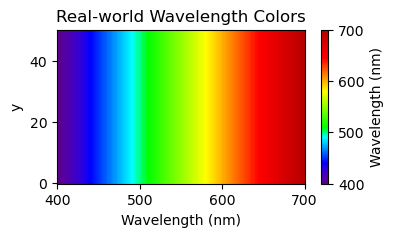

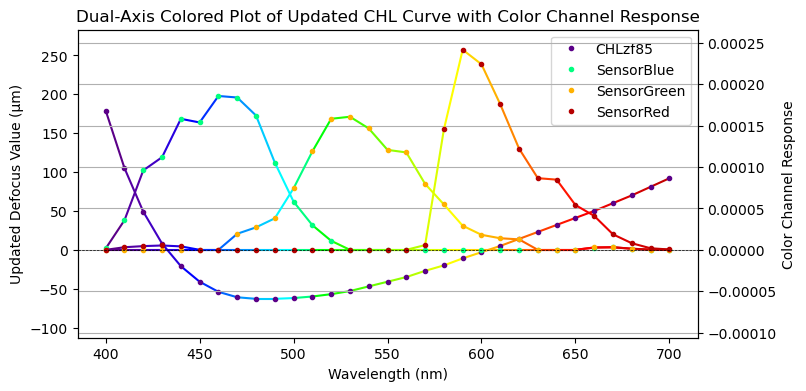

In [33]:
# --------------------------------------------------------------------
# Combined Plotting Script: Wavelength Density Plot and Dual-Axis Plot
# --------------------------------------------------------------------
# This script creates two plots:
#    - A density plot using a custom wavelength-based colormap (400–700 nm).
#    - A dual-axis plot overlaying global CHLfit data and sensor data.
#
# Input:
#    - global_CHLfit, x_fit
#    - SensorBlue_norm, SensorGreen_norm, SensorRed_norm
# --------------------------------------------------------------------

def wavelength_to_rgb(wavelength, gamma_cmap=1):
    """Convert wavelength (nm) to an approximate RGB value."""
    if 380 <= wavelength < 440:
        att = 0.3 + 0.7*(wavelength - 380)/60.0
        return (((440 - wavelength)/60.0 * att)**gamma_cmap, 0.0, (att)**gamma_cmap)
    elif 440 <= wavelength < 490:
        return (0.0, ((wavelength - 440)/50.0)**gamma_cmap, 1.0)
    elif 490 <= wavelength < 510:
        return (0.0, 1.0, ((510 - wavelength)/20.0)**gamma_cmap)
    elif 510 <= wavelength < 580:
        return (((wavelength - 510)/70.0)**gamma_cmap, 1.0, 0.0)
    elif 580 <= wavelength < 645:
        return (1.0, ((645 - wavelength)/65.0)**gamma_cmap, 0.0)
    elif 645 <= wavelength <= 780:
        att = 0.3 + 0.7*(780 - wavelength)/135.0
        return ((att)**gamma_cmap, 0.0, 0.0)
    else:
        return (0.0, 0.0, 0.0)

# Create custom colormap from 400 to 700 nm using x_fit instead of wavelengths
colors = [wavelength_to_rgb(w) for w in x_fit]
cmap = mcolors.LinearSegmentedColormap.from_list("wavelength_cmap", colors)

# -------------------------------
# Density Plot using pcolormesh with Wavelength Colors
# -------------------------------
y_vals = np.linspace(0, 50, 100)
X, Y = np.meshgrid(x_fit, y_vals)
Z = X  # the x-coordinate (wavelength) as data
plt.figure(figsize=(4, 2))
plt.pcolormesh(X, Y, Z, shading='auto', cmap=cmap)
plt.colorbar(label='Wavelength (nm)')
plt.title('Real-world Wavelength Colors')
plt.xlabel('Wavelength (nm)')
plt.ylabel('y')
plt.show()

# -------------------------------
# Dual-Axis Plot: Global CHLfit and Sensor Data
# -------------------------------
def plot_gradient(ax, x, y, cmap):
    """Plot line segments between adjacent points colored by wavelength."""
    norm = plt.Normalize(400, 700)
    for j in range(len(x) - 1):
        ax.plot(x[j:j+2], y[j:j+2], color=cmap(norm(x[j])))

# Define global y-axis limits and margins.
global_min, global_max = -80, 250
margin = 0.1 * (global_max - global_min)
g_min, g_max = global_min - margin, global_max + margin
r = (0 - g_min) / (g_max - g_min)

# Compute sensor data limits.
sens_max = max(SensorBlue_norm[:, 1].max(),
               SensorGreen_norm[:, 1].max(),
               SensorRed_norm[:, 1].max())
sens_margin = 0.1 * sens_max
sens_max_new = sens_max + sens_margin
sens_min_new = - (r / (1 - r)) * sens_max_new

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()
ax1.set_ylim(g_min, g_max)
ax2.set_ylim(sens_min_new, sens_max_new)

# Plot global CHLfit data.
plot_gradient(ax1, global_CHLfit[:, 0], global_CHLfit[:, 1], cmap)
ax1.plot(global_CHLfit[:, 0], global_CHLfit[:, 1], 'o', markersize=3, color=cmap(0), label='CHLzf85')

# Plot sensor data.
sensors = [SensorBlue_norm, SensorGreen_norm, SensorRed_norm]
sensor_names = ['SensorBlue', 'SensorGreen', 'SensorRed']
for i, (sensor, name) in enumerate(zip(sensors, sensor_names), start=1):
    plot_gradient(ax2, sensor[:, 0], sensor[:, 1], cmap)
    ax2.plot(sensor[:, 0], sensor[:, 1], 'o', markersize=3, color=cmap(i/3), label=name)

# Add horizontal reference lines, labels, and legends.
ax1.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax2.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Updated Defocus Value (μm)')
ax2.set_ylabel('Color Channel Response')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.title('Dual-Axis Colored Plot of Updated CHL Curve with Color Channel Response')
plt.grid(True)
plt.show()

In [19]:
# --------------------------------------------------------------------
# Setup for Sensor Data Processing, Edge Functions & Grid Search
# --------------------------------------------------------------------
# Data Setup for Sensor Channels:
#   - Convert sensor data from the normalized sensor arrays to NumPy arrays
#     with float64 precision for accurate computations.
#
# Global Constants and Parameters:
#   - K: A constant used in sensor data processing or modeling.
#   - xrange_val: Range for x values in plots (e.g., visualization limits).
#   - defocusrange: Controls the defocus range during focus analysis.
#   - tol: Tolerance value for color width calculations.
#   - F_value: Parameter used in model fitting or sensor data processing.
#   - g_value: Parameter likely related to sensor processing or edge function computation.
# --------------------------------------------------------------------

# Data Setup for Sensor Channels
SensorBluedata = np.asarray(SensorBlue_norm[:, 1], dtype=np.float64)
SensorGreendata = np.asarray(SensorGreen_norm[:, 1], dtype=np.float64)
SensorReddata  = np.asarray(SensorRed_norm[:, 1], dtype=np.float64)

# Global Constants and Parameters
K = 1.4
xrange_val = 400
defocusrange = 1000
tol = 0.15
F_value = 8
gamma_value = 1

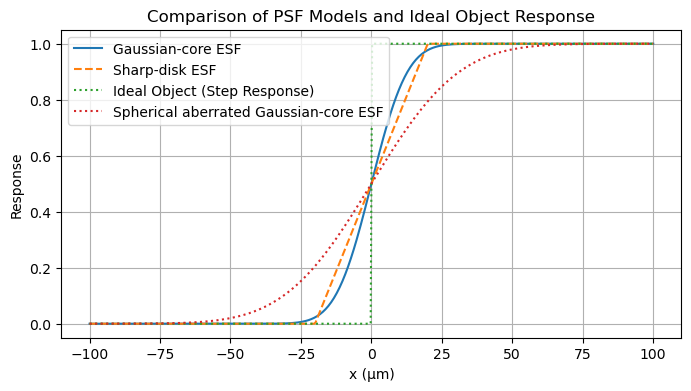

In [27]:
# ----------------------------------------------------------
# Input:
#   - Sensor data arrays and CHL data.
#   - Parameters: Exposure (F), Gamma (gamma), spatial increment (dx), constant (K).
#   - x coordinate values and ratio for PSF transition.
#
# Process:
#   - Compute normalized exposure using a hyperbolic tangent scaling.
#   - Evaluate PSFs (linear and Gaussian) based on the given ratio.
#   - Integrate sensor responses weighted by the PSF to compute the edge response.
#   - Plot the PSF models for visual comparison along with an ideal step response.
#
# Output:
#   - An edge response value for each sensor channel (red, green, blue).
#   - A plot comparing the Gaussian PSF, linear (ideal) PSF, and the ideal step response.
# ----------------------------------------------------------

# ---------------------- JIT-Compiled Functions ----------------------
from numba import njit
from math import erf as math_erf, tanh, sqrt, pi, exp, fabs
@njit
def Exposure_jit(x, F):
    """Compute the normalized exposure using a hyperbolic tangent scaling."""
    return np.tanh(F * x) / np.tanh(F)

@njit
def linear_ESF_jit(x: float, ratio: float) -> float:
    """Compute a linear PSF with a step-like behavior for negligible ratio."""
    if ratio < 1e-6:
        return 1.0 if x >= 0 else 0.0
    if x >= ratio:
        return 1.0
    elif x <= -ratio:
        return 0.0
    else:
        return 0.5 * (1 + x / ratio)

@njit
def gaussian_ESF_jit(x: float, ratio: float) -> float:
    """Compute a Gaussian-based PSF using a smooth error function transition."""
    if ratio < 1e-6:
        return 1.0 if x >= 0 else 0.0
    return 0.5 * (1.0 + math_erf(x / (sqrt(2) * 0.5 * ratio)))

@njit
def spherical_ESF_jit(x: float, ratio: float) -> float:
    """
    Spherical aberrated ESF using Gaussian model scaled by Strehl ratio:
    phi_sigma = 2pi * zernike_coef (in waves)
    Strehl S = exp(-phi_sigma^2)
    """
    zernike_coef = 0.1
    phi_sigma = 2 * pi * zernike_coef
    strehl = exp(-phi_sigma**2)
    if ratio < 1e-6:
        return strehl if x >= 0 else 0.0
    return 0.5 * (1.0 + math_erf(x / ratio * sqrt(strehl * 0.5)))


@njit
def compute_edge_jit(x: float, z: float, F: float, gamma: float, sensor_data, CHLdata, dx: float, K: float, psf_mode: str) -> float:
    """
    Compute the edge response by weighting sensor data with a PSF.
    
    For each CHL data point, calculates a weight (using a linear or Gaussian PSF) and
    accumulates a weighted sensor sum. The result is normalized and processed through
    an exposure function with gamma correction.
    """
    denom_factor = sqrt(4 * K**2 - 1)
    num = 0.0
    for n in range(len(CHLdata)):
        ratio = fabs((z - CHLdata[n]) / denom_factor)
         
        if psf_mode.lower() == "linear":
            weight = linear_ESF_jit(x, ratio)
        elif psf_mode.lower() == "gaussian":
            weight = gaussian_ESF_jit(x, ratio) 
        elif psf_mode.lower() == "spherical":
            weight = spherical_ESF_jit(x, ratio)
        else:
            weight = 0.0  # fallback for unknown mode
        num += sensor_data[n] * weight

    den = 0.0
    for val in sensor_data:
        den += val
    return Exposure_jit(num / den, F) ** gamma

# ---------------------- Edge Function Wrappers ----------------------
sensor_map = {"R": SensorReddata, "G": SensorGreendata, "B": SensorBluedata}

def Edge(color: str, x: float, z: float, F: float, gamma: float, CHLdata, dx: float, K: float, psf_mode: str = "gaussian") -> float:
    """
    General edge function wrapper for a specified sensor channel.
    
    Parameters:
        color (str): Sensor color, 'R', 'G', or 'B'.
        x, z, F, gamma, CHLdata, dx, K, psf_mode: Parameters passed to compute_edge_jit.
    
    Returns:
        float: Computed edge response.
    """
    sensor_data = sensor_map[color.upper()]
    return compute_edge_jit(x, z, F, gamma, sensor_data, CHLdata, dx, K, psf_mode)

# ---------------------- PSF Aliases & Plotting ----------------------
# Define x range and PSF transition parameter "ratio"
x_vals = np.linspace(-100, 100, 400)
ratio_value = 20  # Adjust as needed based on the sensor characteristics

# Compute PSF values for plotting
y_linear = np.array([linear_ESF_jit (val, ratio_value) for val in x_vals])
y_gaussian = np.array([gaussian_ESF_jit(val, ratio_value) for val in x_vals])
y_spherical = np.array([spherical_ESF_jit(val, ratio_value) for val in x_vals])
# The step response represents an ideal object boundary (no blurring)
y_ideal_step = np.where(x_vals < 0, 0, 1)

# Plot the PSF models and ideal object step response
plt.figure(figsize=(8, 4))
plt.plot(x_vals, y_gaussian, label=r'Gaussian-core ESF')
plt.plot(x_vals, y_linear, '--', label='Sharp-disk ESF')
plt.plot(x_vals, y_ideal_step, ':', label='Ideal Object (Step Response)')
plt.plot(x_vals, y_spherical, ':', label='Spherical aberrated Gaussian-core ESF')
plt.xlabel("x (μm)")
plt.ylabel("Response")
plt.title("Comparison of PSF Models and Ideal Object Response")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# --- Helper Functions for Color Fringe Calculations ---

def Farbsaum(x, z, F, gamma, CHLdata, psf_mode: str = "gaussian"):
    """
    Determine if a significant color difference exists (binary decision)
    using sensor edge responses.

    Returns:
        int: 1 if the absolute differences between channels exceed tol, else 0.
    """
    r = Edge("R", x, z, F, gamma, CHLdata, dx, K, psf_mode)
    g = Edge("G", x, z, F, gamma, CHLdata, dx, K, psf_mode)
    b = Edge("B", x, z, F, gamma, CHLdata, dx, K, psf_mode)
    return 1 if (abs(r - b) > tol or abs(r - g) > tol or abs(g - b) > tol) else 0


def Farbsaumbreite(z, F, gamma, CHLdata, psf_mode: str = "gaussian"):
    """
    Compute the overall color fringe width (binary method) for a given defocus (z).

    Returns:
        int: Aggregated binary width value.
    """
    xs = np.arange(-int(np.floor(xrange_val)), int(np.floor(xrange_val)) + 1)
    return np.sum([Farbsaum(x, z, F, gamma, CHLdata, psf_mode) for x in xs])


def ColorFringe(x, z, F, gamma, CHLdata, psf_mode: str = "gaussian"):
    """
    Compute the color fringe responses for a given x position.

    Returns:
        Tuple: (EdgeR, EdgeG, EdgeB) values.
    """
    return (
        Edge("R", x, z, F, gamma, CHLdata, dx, K, psf_mode),
        Edge("G", x, z, F, gamma, CHLdata, dx, K, psf_mode),
        Edge("B", x, z, F, gamma, CHLdata, dx, K, psf_mode)
    )

In [34]:
# (Ensure that global_CHLfit has been updated via get_modified_CHL_array before using.)
CHLdata_0 = global_CHLfit[:, 1] if global_CHLfit is not None else None

# --- Interactive Plotting for Edge Functions and Density Plot ---
def update_plots(z, F, gamma, model):
    """
    Interactive update for the edge spread function plots and the density plot.
    
    Parameters:
        z (float): Defocus position.
        F (float): Exposure parameter.
        gamma (float): Gamma correction factor.
        model (str): PSF model ('Linear PSF' or 'Gaussian PSF').
    """
    # Set psf_mode based on the model selection:
    psf_mode = "gaussian" if model == 'Gaussian PSF' else "linear"
    xs = np.linspace(-xrange_val, xrange_val, 400)
    
    # Compute the edge function values for each sensor channel using the generic Edge function.
    edgeR_vals = np.array([Edge("R", x, z, F, gamma, CHLdata_0, dx, K, psf_mode) for x in xs])
    edgeG_vals = np.array([Edge("G", x, z, F, gamma, CHLdata_0, dx, K, psf_mode) for x in xs])
    edgeB_vals = np.array([Edge("B", x, z, F, gamma, CHLdata_0, dx, K, psf_mode) for x in xs])
    
    # Compute the color difference binary decision for each x value.
    farb_vals = np.array([Farbsaum(x, z, F, gamma, CHLdata_0, psf_mode) for x in xs])
    
    # Plot the edge functions.
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(xs, edgeR_vals, label='EdgeR')
    ax1.plot(xs, edgeG_vals, label='EdgeG')
    ax1.plot(xs, edgeB_vals, label='EdgeB')
    ax1.plot(xs, farb_vals, label='Farbsaum')
    ax1.set_title(f"Edge Functions ({model})")
    ax1.set_xlabel("x (μm)")
    ax1.set_ylabel("Response")
    ax1.set_ylim(0, 1)
    ax1.legend()
    ax1.grid(True)
    
    # Create a density plot using ColorFringe (1D slice replicated vertically)
    ax2 = fig.add_subplot(1, 2, 2)
    X = np.linspace(-xrange_val, xrange_val, 200)
    Y = np.linspace(0, 0.5 * xrange_val, 100)
    XX, YY = np.meshgrid(X, Y)
    
    img = np.zeros((YY.shape[0], YY.shape[1], 3))
    for i in range(YY.shape[0]):
        for j in range(YY.shape[1]):
            img[i, j, :] = ColorFringe(XX[i, j], z, F, gamma, CHLdata_0, psf_mode)
    img = np.clip(img, 0, 1)
    ax2.imshow(img, extent=[-xrange_val, xrange_val, 0, 0.5 * xrange_val], aspect='auto')
    ax2.set_title("Density Plot (ColorFringe)")
    ax2.set_xlabel("x (μm)")
    ax2.set_ylabel("y (μm)")
    
    plt.tight_layout()
    plt.show()
    
    # Compute and print overall color fringe width.
    width = Farbsaumbreite(z, F, gamma, CHLdata_0, psf_mode)
    print("Color fringe width =", width)


# Interactive widget for edge functions.
interact(update_plots,
         z=FloatSlider(min=-defocusrange, max=defocusrange, step=1, value=0, description="Defocus (μm)"),
         F=FloatSlider(min=1, max=16, step=1, value=F_value, description="Exposure F"),
         gamma=FloatSlider(min=0.5, max=20, step=0.5, value=gamma_value, description="Gamma"),
         model=RadioButtons(options=['Gaussian-core PSF','Sharp-disk PSF'], description='PSF'))

interactive(children=(FloatSlider(value=0.0, description='Defocus (μm)', max=1000.0, min=-1000.0, step=1.0), F…

<function __main__.update_plots(z, F, gamma, model)>

In [36]:
# --- Functions for Farbsaumbreite vs. Defocus Plot ---
dd = 10  # Step size for defocus values
z_vals = np.arange(-defocusrange, defocusrange + 1, dd)  # Defocus positions along the optical axis

def plot_farbs(F_value, label, psf_mode):
    """
    For each z in z_vals, calculate the "Farbsaumbreite" (color fringe width)
    using the binary method and plot these widths versus the defocus values.

    Parameters:
        F_value (float): The exposure parameter.
        label (str): Label for the plot.
        psf_mode (str): PSF mode ('linear' for Linear PSF; 'gaussian' for Gaussian PSF).
    
    Returns:
        np.ndarray: Data array with columns [z, Farbsaumbreite].
    """
    data = np.array([[z, Farbsaumbreite(z, F_value, gamma_value, CHLdata_0, psf_mode)] for z in z_vals])
    plt.plot(data[:, 0], data[:, 1], 'o-', markersize=3, label=label)
    return data


def plot_farbs_comparison(F_values=[2], weight_function_choice="Gaussian PSF"):
    """
    Plot Farbsaumbreite for various F values using the selected PSF model.

    Parameters:
        F_values (list): List of exposure (F) values.
        weight_function_choice (str): 'Linear PSF' or 'Gaussian PSF'.
    
    Returns:
        dict: A dictionary mapping each F value to its computed data array.
    """
    plt.figure(figsize=(8, 4))
    data_dict = {}
    psf_mode = "gaussian" if weight_function_choice == "Gaussian PSF" else "linear"
    
    for F_val in sorted(F_values):
        data_dict[F_val] = plot_farbs(F_val, f"F={F_val}", psf_mode)
    
    model_name = weight_function_choice
    plt.title(f"Color Fringe Width for various F values using {model_name}")
    plt.xlabel("z defocus (μm)")
    plt.ylabel("Color Fringe Width (μm)")
    plt.legend()
    plt.grid(True)
    plt.show()
    return data_dict


def interactive_plot(F_values, weight_function_choice):
    """
    Interactive function to plot Farbsaumbreite comparison for selected F values
    and PSF model.
    
    Parameters:
        F_values (list): List of exposure F values.
        weight_function_choice (str): 'Linear PSF' or 'Gaussian PSF'.
    """
    F_values = sorted(F_values)
    plot_farbs_comparison(F_values=F_values, weight_function_choice=weight_function_choice)


# Interactive widgets for Farbsaumbreite plot.
F_values_widget = widgets.SelectMultiple(
    options=[1, 2, 4, 8, 16],
    value=[1, 2, 4, 8],
    description='F values',
    disabled=False
)

weight_function_widget = widgets.RadioButtons(
    options=['Gaussian-core PSF', 'Sharp-disk PSF'],
    value='Gaussian-core PSF',
    description='PSF',
    disabled=False
)

# Measure the runtime of the interactive plot setup.
start_time = time.time()  # Start timer
interact(interactive_plot, 
         F_values=F_values_widget, 
         weight_function_choice=weight_function_widget)
end_time = time.time()  # End timer

print("Runtime: {:.3f} seconds".format(end_time - start_time))


interactive(children=(SelectMultiple(description='F values', index=(0, 1, 2, 3), options=(1, 2, 4, 8, 16), val…

Runtime: 10.282 seconds


In [15]:
def evaluate_params(params):
    """
    Evaluate a single (x_shift, tilt) parameter combination by computing the 
    aggregated Farbsaumbreite value over the range of defocus positions.

    For each (x_shift, tilt):
      - Compute the modified CHL curve and extract CHL data.
      - For each defocus position (z) in z_vals, calculate the Farbsaumbreite.
      - Aggregate these values using the selected aggregation_mode (mean, mean_center, or max).
        For the "mean_center" mode, only the range between the left and right global maximum
        fringe values (based on their positions in the array) is averaged.

    Parameters:
        params (tuple): (x_shift, tilt)

    Returns:
        tuple: (x_shift, tilt, aggregated_width)
    """
    x_shift, tilt = params
    # Compute the modified CHL curve for the current parameters.
    CHL_matrix = extract_sampled_modified_values_overall(x_shift, tilt)
    CHLdata_local = CHL_matrix[:, 1]
    
    # Calculate Farbsaumbreite for each defocus position.
    # Here, gamma is set to 1 and the PSF is fixed as "gaussian".
    fringe_values = [
        Farbsaumbreite(z, F_value, 1, CHLdata_local, psf_mode="gaussian")
        for z in z_vals
    ]
    
    # Aggregate the fringe values based on the selected aggregation_mode.
    if aggregation_mode == "mean_center":
        # Split the fringe values at the midpoint.
        mid_index = len(fringe_values) // 2
        
        # Find the index of the maximum value in the left segment (from the start to the midpoint).
        left_segment = fringe_values[:mid_index+1]  # include midpoint for safety
        left_max_idx = np.argmax(left_segment)
        
        # Find the index of the maximum value in the right segment (from the midpoint to the end).
        right_segment = fringe_values[mid_index:]
        right_max_idx = np.argmax(right_segment) + mid_index  # adjust index relative to whole array
        
        # Use the smaller index as left and the larger as right.
        left_index = min(left_max_idx, right_max_idx)
        right_index = max(left_max_idx, right_max_idx)
        
        # Compute the mean only over the values between (and including) the two global maximum indices.
        aggregated_width = np.mean(fringe_values[left_index:right_index+1])
    
    elif aggregation_mode == "max":
        aggregated_width = np.max(fringe_values)
    elif aggregation_mode == "mean":
        aggregated_width = np.mean(fringe_values)
    else:
        aggregated_width = np.max(fringe_values)  # default fallback
    
    return (x_shift, tilt, aggregated_width)


def grid_search():
    """
    Perform a grid search over x_shift and tilt parameters using parallel threads.

    Returns:
        tuple: (best_params, results_array, x_shift_values, tilt_values)
    """
    # Define grid ranges for x_shift and tilt.
    x_shift_values = np.linspace(-80, 80, num=21)
    tilt_values = np.linspace(-0.8, 0.8, num=21)
    param_grid = [(x_shift, tilt) for x_shift in x_shift_values for tilt in tilt_values]
    
    # Evaluate each parameter combination in parallel.
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(evaluate_params, param_grid))
    
    results_array = np.array(results)
    # Find the combination with the smallest aggregated fringe width.
    min_index = np.argmin(results_array[:, 2])
    best_params = results_array[min_index]
    return best_params, results_array, x_shift_values, tilt_values


Best parameters found based on max width:
λ-shift: -32.00 nm, tilt: -0.80, CFW: 16.00 μm
Grid search took 2010.52 seconds


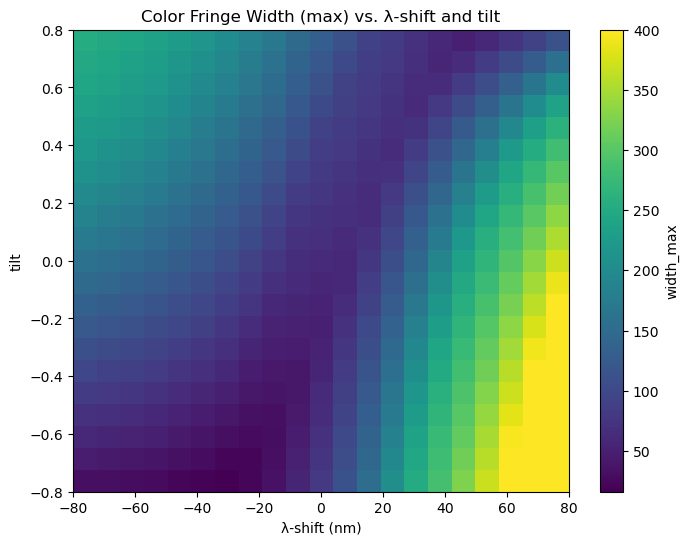

Plotting cell run time: 0.1678 seconds


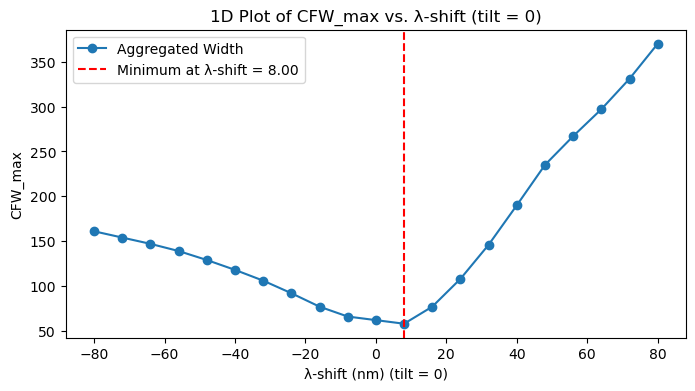

Minimum CFW_max for tilt=0 is found at λ-shift = 8.00 nm


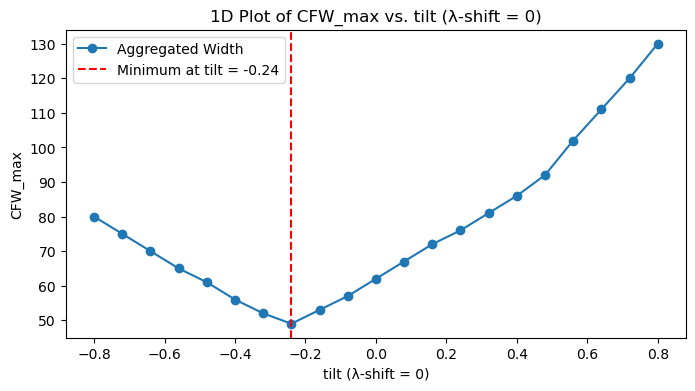

Minimum CFW_max for λ-shift=0 is found at tilt = -0.24


In [38]:
# --- Main Execution Block ---
aggregation_mode = "max"  # Options: "mean" or "max" (or "mean_center" if desired)

if __name__ == "__main__":
    start_time = time.time()
    best_params, results_array, x_shift_values, tilt_values = grid_search()
    end_time = time.time()
    
    # Identify all parameter combinations with the minimum aggregated fringe width.
    min_width = results_array[:, 2].min()
    tol_min = 1e-3  # Tolerance for floating point comparison
    min_indices = np.where(np.isclose(results_array[:, 2], min_width, atol=tol_min))[0]
    
    print("Best parameters found based on", aggregation_mode, "width:")
    for idx in min_indices:
        x_shift, tilt, width_value = results_array[idx]
        print("λ-shift: {:.2f} nm, tilt: {:.2f}, CFW: {:.2f} μm".format(x_shift, tilt, width_value))
    print("Grid search took {:.2f} seconds".format(end_time - start_time))
    
    # Plot aggregated fringe width values as a 2D heatmap.
    plot_start_time = time.perf_counter()
    
    # Reshape results_array into a matrix where rows correspond to x_shift and columns to tilt.
    width_matrix = results_array[:, 2].reshape(len(x_shift_values), len(tilt_values))
    
    plt.figure(figsize=(8, 6))
    plt.imshow(width_matrix.T,  # Transpose so that tilt is on the y-axis.
               extent=[x_shift_values.min(), x_shift_values.max(),
                       tilt_values.min(), tilt_values.max()],
               origin='lower', aspect='auto')
    plt.xlabel('λ-shift (nm)')
    plt.ylabel('tilt')
    plt.title(f'Color Fringe Width ({aggregation_mode}) vs. λ-shift and tilt')
    plt.colorbar(label=f'width_{aggregation_mode}')
    plt.show()
    
    plot_end_time = time.perf_counter()
    print(f"Plotting cell run time: {plot_end_time - plot_start_time:.4f} seconds")
    
    # --- Additional 1D plots extracted from precomputed results ---
    
    # 1. Fixed tilt = 0: Plot aggregated width vs. x_shift.
    tilt_index = np.where(np.isclose(tilt_values, 0))[0][0]
    width_line_tilt0 = width_matrix[:, tilt_index]
    min_index_shift = np.argmin(width_line_tilt0)
    best_x_shift = x_shift_values[min_index_shift]
    
    plt.figure(figsize=(8, 4))
    plt.plot(x_shift_values, width_line_tilt0, 'o-', label='Aggregated Width')
    plt.xlabel('λ-shift (nm) (tilt = 0)')
    plt.ylabel(f'CFW_{aggregation_mode}')
    plt.title(f'1D Plot of CFW_{aggregation_mode} vs. λ-shift (tilt = 0)')
    plt.axvline(x=best_x_shift, color='r', linestyle='--', label=f'Minimum at λ-shift = {best_x_shift:.2f}')
    plt.legend()
    plt.show()
    
    print(f"Minimum CFW_{aggregation_mode} for tilt=0 is found at λ-shift = {best_x_shift:.2f} nm")
    
    # 2. Fixed x_shift = 0: Plot aggregated width vs. tilt.
    shift_index = np.where(np.isclose(x_shift_values, 0))[0][0]
    width_line_shift0 = width_matrix[shift_index, :]
    min_index_tilt = np.argmin(width_line_shift0)
    best_tilt = tilt_values[min_index_tilt]
    
    plt.figure(figsize=(8, 4))
    plt.plot(tilt_values, width_line_shift0, 'o-', label='Aggregated Width')
    plt.xlabel('tilt (λ-shift = 0)')
    plt.ylabel(f'CFW_{aggregation_mode}')
    plt.title(f'1D Plot of CFW_{aggregation_mode} vs. tilt (λ-shift = 0)')
    plt.axvline(x=best_tilt, color='r', linestyle='--', label=f'Minimum at tilt = {best_tilt:.2f}')
    plt.legend()
    plt.show()
    
    print(f"Minimum CFW_{aggregation_mode} for λ-shift=0 is found at tilt = {best_tilt:.2f}")
